# Making Features Discrete
In previous weeks we have imputed values and made new variables using the `pandas.cut` function to define how to make a single attribute discrete. In this module, let's instead use clustering to convert one or more features into discrete, categorical features (integers). 

The process will be simple:
- Choose a subset of features from the dataset to cluster upon
- Cluster the features assuming according to a given algorithm
- Replace the features with their discrete cluster labels as a form of discretization
- Perform classification using the new feature from the dataset

In this notebook, we will investigate simple clustering methods for making the clusters discrete: kmeans, hierarchical agglomerative clustering, and DBSCAN. The dataset we will use comes from our titanic dataset that we have used in the past.

In [2]:
import pandas as pd
import numpy as np
#from __future__ import print_function

df = pd.read_csv('data/titanic.csv') # read in the csv file

# 1. Remove attributes that just arent useful for us
del df['PassengerId']
del df['Name']
del df['Cabin']
del df['Ticket']

# 2. Impute some missing values, grouped by their Pclass and SibSp numbers
df_grouped = df.groupby(by=['Pclass','SibSp'])

# # now use this grouping to fill the data set in each group, then transform back
# fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
# fill in the categorical values
df_imputed[['Sex','Embarked']] = df_grouped[['Sex','Embarked']].apply(lambda grp: grp.fillna(grp.mode()))
# fillin the grouped variables from original data frame
df_imputed[['Pclass','SibSp']] = df[['Pclass','SibSp']]

# 4. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)

# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','Sex','Parch','SibSp','Pclass','Fare','Embarked']]

# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(df_imputed.Embarked,prefix='Embarked')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# replace the current Sex atribute with something slightly more intuitive and readable
df_imputed['IsMale'] = df_imputed.Sex=='male' 
df_imputed.IsMale = df_imputed.IsMale.astype(np.int)

# Now let's clean up the dataset
if 'Sex' in df_imputed:
    del df_imputed['Sex'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Embarked' in df_imputed:    
    del df_imputed['Embarked'] # get reid of the original category as it is now one-hot encoded

# Finally, let's create a new variable based on the number of family members
# traveling with the passenger

# notice that this new column did not exist before this line of code--we use the pandas 
#    syntax to add it in 
df_imputed['FamilySize'] = df_imputed.Parch + df_imputed.SibSp

##################################################################################################
# 6. Normalizing the variables is very important since we are looking at distance between points
##################################################################################################
y = df_imputed['Survived']
df_imputed = (df_imputed-df_imputed.mean())/df_imputed.std()
df_imputed['Survived'] = y

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 11 columns):
Survived      882 non-null int64
Age           882 non-null float64
Parch         882 non-null float64
SibSp         882 non-null float64
Pclass        882 non-null float64
Fare          882 non-null float64
Embarked_C    882 non-null float64
Embarked_Q    882 non-null float64
Embarked_S    882 non-null float64
IsMale        882 non-null float64
FamilySize    882 non-null float64
dtypes: float64(10), int64(1)
memory usage: 82.7 KB


For this dataset, it probably makes sense to try and cluster `PClass` and `Fare` together because they have similar information and can likely be combined. It is unclear exactly where to make the classes discrete and how many levels we should make, so we will try a few different parameterizations to investigate this.

It also might make sense to make the `Age`, `Parch`, and `SibSp` cariables into a single discrete variable representing clusters of families. Again, we will need to try different parameterizations (numbers of cluster and the algorithm for clustering).

## Baseline Classification Performance
Let's start by performing 10 fold cross validation and using the raw features in a Random Forest classifer. Let's get the average accuracy of classifying whther a person survives or does not from the Titanic.

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = df_imputed['Survived']
X = df_imputed[['Age','IsMale','Parch','SibSp','Pclass','Fare']]
cv = StratifiedKFold(n_splits=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  80.39708886618999 +- 5.045612616288555


Okay, now let's start with a bit of feature engineering. We will start by using kmeans on `PClass` and `Fare` together.

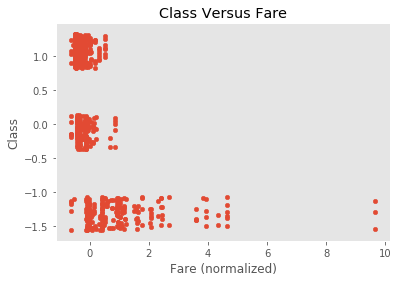

In [6]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = df_imputed[['Pclass','Fare']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Fare (normalized)'), plt.ylabel('Class')
plt.grid()
plt.title('Class Versus Fare')
plt.show()

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X1 = df_imputed[['Pclass','Fare']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['Age','IsMale','Parch','SibSp']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for class/fare)=  79.7152706843718 +- 3.845908709945106


So it seems that the average accuracy of the folds has stayed about the same, but the deviation from the mean has been considerably decreased. Let's now try adding in different discretization of the features.

In [7]:
from sklearn.cluster import KMeans
import numpy as np

X2 = df_imputed[['Age','Parch','SibSp']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['IsMale','Pclass','Fare']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for Age/Family)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for Age/Family)=  80.16215526046986 +- 3.7567436129623584


This discretization actually helps increase the accuracy on average, but not really helping in the lowering of the deviation from the mean. What if we combine the different clusterings?

In [8]:
# get the first clustering
cls_fare = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['IsMale']]
X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  80.50051072522983 +- 3.7862956870539852


It seems this is not quite as accurate, but we still need to vary the parameters and see what works.

In [9]:
%%time 

X1 = df_imputed[['Pclass','Fare']]
X2 = df_imputed[['Age','Parch','SibSp']]

params = []
for n_fare in range(4,10):
    for n_fam in range(16,19):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X1)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['IsMale']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("Clusters",n_fare,n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 4 16 Average accuracy =  79.93615934627172 +- 3.1747448089989154
Clusters 4 17 Average accuracy =  80.27579162410623 +- 2.4652003753279383
Clusters 4 18 Average accuracy =  80.164708886619 +- 3.2965288523273064
Clusters 5 16 Average accuracy =  80.6179775280899 +- 3.8085302958456815
Clusters 5 17 Average accuracy =  80.95760980592442 +- 3.2090872286548944
Clusters 5 18 Average accuracy =  80.73161389172624 +- 3.6222466826306388
Clusters 6 16 Average accuracy =  80.27706843718079 +- 3.1809462736520384
Clusters 6 17 Average accuracy =  80.84141981613891 +- 3.254662646179412
Clusters 6 18 Average accuracy =  80.16343207354441 +- 2.9789950780074688
Clusters 7 16 Average accuracy =  80.16598569969355 +- 3.512476333980917
Clusters 7 17 Average accuracy =  80.50434116445352 +- 3.402453867221031
Clusters 7 18 Average accuracy =  79.82379979570992 +- 3.081295722041821
Clusters 8 16 Average accuracy =  79.48416751787536 +- 3.4964765475878212
Clusters 8 17 Average accuracy =  79.93232890

It seems that about the best we can do with these new discretization methods is around 82%. All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable. 

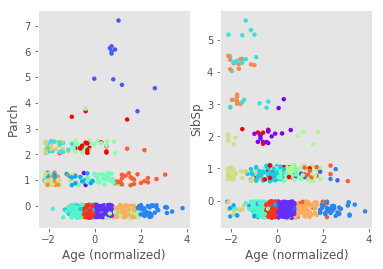

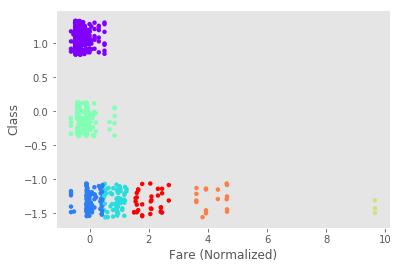

In [10]:
n_fare=7
d_fam=17

X1 = df_imputed[['Pclass','Fare']]
X2 = df_imputed[['Age','Parch','SibSp']]

cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
X2=X2.values
plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age (normalized)'), plt.ylabel('Parch')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X2[:, 0], X2[:, 2]+np.random.random(X2[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age (normalized)'), plt.ylabel('SibSp')
plt.grid()

X1=X1.values
plt.figure()
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Fare (Normalized)'), plt.ylabel('Class')
plt.grid()

Let's see if we can make things simpler by only clustering on one set of attributes.

In [11]:

params = []
for n_fam in range(15,20):

    # append on the clustering
    cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
    cls_fam.fit(X2)
    newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

    y = df_imputed['Survived']
    X = df_imputed[['IsMale','Pclass','Fare']]
    X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

    print ("Clusters",n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 15 Average accuracy =  79.37691521961185 +- 3.780870970269433
Clusters 16 Average accuracy =  79.03600612870275 +- 4.281470289045025
Clusters 17 Average accuracy =  79.26072522982636 +- 3.7430142773903503
Clusters 18 Average accuracy =  78.8100102145046 +- 4.78260228160649
Clusters 19 Average accuracy =  78.92109295199182 +- 3.5309154609918703


So it seems that the accuracy is fairly stagnant, but has a tight standard deviation. Now, let's also try to replace features using some slightly different clustering algorithms and see what works best for classification.

In [12]:
%%time 

from sklearn.cluster import AgglomerativeClustering

X1 = df_imputed[['Pclass','Fare']]

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(13,20):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['IsMale','Pclass','Fare']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

C= 13 ward Average accuracy =  80.73161389172625 +- 2.7337665212259945
C= 14 ward Average accuracy =  79.82635342185904 +- 3.146493336715587
C= 15 ward Average accuracy =  80.16598569969355 +- 3.169816457786219
C= 16 ward Average accuracy =  80.16726251276813 +- 3.2398464420989077
C= 17 ward Average accuracy =  79.9399897854954 +- 3.235634033408536
C= 18 ward Average accuracy =  80.05362614913176 +- 3.159011013084148
C= 19 ward Average accuracy =  79.93871297242083 +- 3.082750348410299
C= 13 complete Average accuracy =  79.71654749744637 +- 5.774807460488014
C= 14 complete Average accuracy =  79.49055158324822 +- 5.923964250975705
C= 15 complete Average accuracy =  79.71654749744637 +- 5.774807460488014
C= 16 complete Average accuracy =  79.94254341164454 +- 5.8154888644582305
C= 17 complete Average accuracy =  79.9438202247191 +- 5.558290980528469
C= 18 complete Average accuracy =  79.48927477017365 +- 5.336575233697369
C= 19 complete Average accuracy =  79.26327885597549 +- 5.3457876

Again, all fairly good performances using different types of linkage and also different numbers of clusters. Let's now try DBSCAN.

In [13]:
%%time 

from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['IsMale','Pclass','Fare']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

0.1 5 Average accuracy =  80.62691521961185 +- 5.598585978999451
0.1 6 Average accuracy =  81.7594484167518 +- 5.301776842282795
0.1 7 Average accuracy =  81.08146067415728 +- 6.029324542104495
0.125 5 Average accuracy =  80.96782431052092 +- 5.7171526426454
0.125 6 Average accuracy =  81.64581205311542 +- 5.163537684228331
0.125 7 Average accuracy =  81.19509703779369 +- 6.095321073704799
0.15 5 Average accuracy =  80.96782431052092 +- 5.7171526426454
0.15 6 Average accuracy =  81.64581205311542 +- 5.163537684228331
0.15 7 Average accuracy =  81.19509703779369 +- 6.095321073704799
Wall time: 18.6 s


It seems that DBSCAN has good clusterings for this dataset that are able to capture some of the nuances for the attributes. Although this is not spatial data, it is interesting that contiguous clustering helps discretize the data a bit (for a small range of eps and minpts). Even so, the center based clustering also tend to do well.

## Visualizing different clusters
Now lets take the best performers from each dataset and show the clustering that they found in the data.

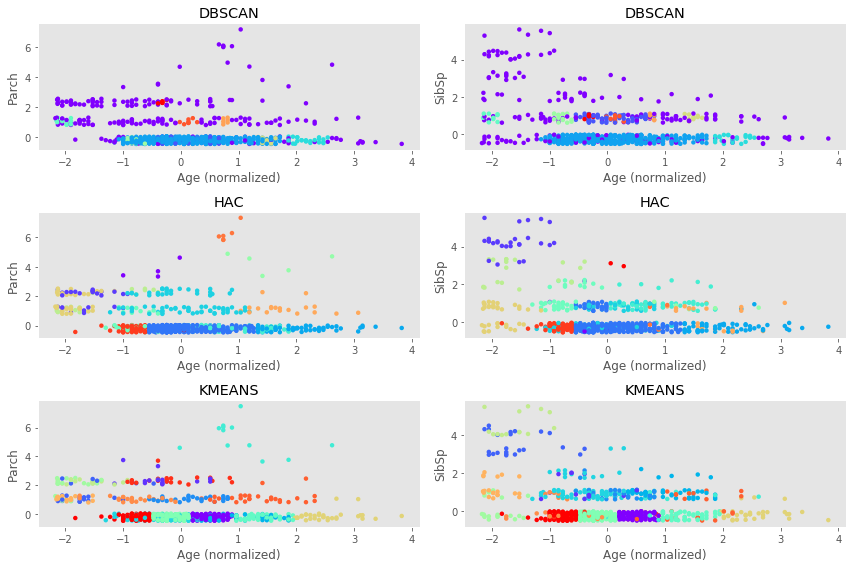

In [14]:


data = X2

cls = DBSCAN(eps=0.125, min_samples=6)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=14, linkage='complete')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=17, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('Parch')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('SibSp')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()